#**Custom Gym Environment : Chopper pilot**

##**I) Import the necessary librairies**

In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random

from gym import Env, spaces
import time
font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

##**II) The custom Environment**

1.   **canvas:** This represents our observation image(the interface).
2.   **x_min, y_min, x_max, y_max:** This defines the legitimate area of our screen where various elements of the screen, such as the Chopper and birds, can be placed. Other areas are reserved for displaying info such as fuel left, rewards, and padding.
3.   **elements:** This stores the active elements stored in the screen at any given time (like chopper, bird, etc.)
4.   **max_fuel:** Maximum fuel that the chopper can hold.

implement the functions: 


*   **reset:** Resets the environment to its initial state and returns the initial observation.When we reset our environment, we need to reset all the state-based variables in our environment. These include things like fuel consumed, episodic return, and the elements present inside the environment.In our case, when we reset our environment, we have nothing but the Chopper in the initial state. We initialize our chopper randomly in an area in the top-left of our image.
*   **step :** Executes a step in the environment by applying an action. Returns the new observation, reward, completion status, and other info.It contain the code to transition our environment from one state to the next given an action.We provide actions to the agent that will control what our chopper does. We basically have 5 actions, which are move right, left, down, up, or do nothing, denoted by 0, 1, 2, 3, and 4, respectively.  
*  **draw_elements_on_canvas:** that basically places the icons of each of the elements present in the game at their respective positions in the observation image.
*   **render:** would render the game in a pop-up window, while rgb_array returns it as a pixel array.
*   **get_action_meanings():** will tell us what integer each action is mapped to for our reference.
*   **has_collided:**helps us determine whether two Point objects (such as a Chopper/Bird, Chopper/Fuel Tank) have collided or not.


In [2]:
class ChopperScape(Env):
    def __init__(self):
        super(ChopperScape, self).__init__()
        

        
        # Define a 2-D observation space
        self.observation_shape = (600, 800, 3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
    
        
        # Define an action space ranging from 0 to 4 
        # We Got 5 actions (right, left, down, up, or do nothing)
        self.action_space = spaces.Discrete(6,)
                        
        # Create a canvas to render the environment images upon 
        self.canvas = np.ones(self.observation_shape) * 1
        
        # Define elements present inside the environment
        self.elements = []
        
        # Maximum fuel chopper can take at once
        self.max_fuel = 1000

        # Define the rewards
        self.rewards = 0
        
        # Permissible area of helicper to be 
        self.y_min = int (self.observation_shape[0] * 0.1)
        self.x_min = 0
        self.y_max = int (self.observation_shape[0] * 0.9)
        self.x_max = self.observation_shape[1]

    def draw_elements_on_canvas(self):
        # Init the canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw the heliopter on canvas
        for elem in self.elements:
            elem_shape = elem.icon.shape
            x,y = elem.x, elem.y
            self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = elem.icon

        text = 'Fuel Left: {} | Rewards: {}'.format(self.fuel_left, self.rewards)

        # Put the info on canvas 
        self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
               0.8, (0,0,0), 1, cv2.LINE_AA)    

    def reset(self):
        # Reset the fuel consumed
        self.fuel_left = self.max_fuel

        # Reset the reward
        self.ep_return  = 0
        self.rewards = 0

        # Number of birds
        self.bird_count = 0
        self.fuel_count = 0

        # Determine a place to intialise the chopper in
        x = random.randrange(int(self.observation_shape[0] * 0.05), int(self.observation_shape[0] * 0.10))
        y = random.randrange(int(self.observation_shape[1] * 0.15), int(self.observation_shape[1] * 0.20))
    
        # Intialise the chopper
        self.chopper = Chopper("chopper", self.x_max, self.x_min, self.y_max, self.y_min)
        self.chopper.set_position(x,y)

        # Intialise the elements 
        self.elements = [self.chopper]

        # Reset the Canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw elements on the canvas
        self.draw_elements_on_canvas()


        # return the observation
        return self.canvas  

    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            cv2.imshow("RL Project", self.canvas)
            cv2.waitKey(10)
        elif mode == "rgb_array":
            return self.canvas
    
    def close(self):
        cv2.destroyAllWindows()  

    def get_action_meanings(self):
        return {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "Do Nothing"}  
    
    def has_collided(self, elem1, elem2):
        x_col = False
        y_col = False

        elem1_x, elem1_y = elem1.get_position()
        elem2_x, elem2_y = elem2.get_position()

        if 2 * abs(elem1_x - elem2_x) <= (elem1.icon_w + elem2.icon_w):
            x_col = True

        if 2 * abs(elem1_y - elem2_y) <= (elem1.icon_h + elem2.icon_h):
            y_col = True

        if x_col and y_col:
            return True
        return False            
    def step(self, action):
        # Flag that marks the termination of an episode
        done = False
    
        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"

        # Decrease the fuel counter 
        self.fuel_left -= 1 
    
        # Reward for executing a step.
        self.rewards += 1      

        # apply the action to the chopper
        if action == 0:
            self.chopper.move(0,5)
        elif action == 1:
            self.chopper.move(0,-5)
        elif action == 2:
            self.chopper.move(5,0)
        elif action == 3:
            self.chopper.move(-5,0)
        elif action == 4:
            self.chopper.move(0,0)

        # Spawn a bird at the right edge with prob 0.01
        if random.random() < 0.01:
            # Spawn a bird
            spawned_bird = Bird("bird_{}".format(self.bird_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.bird_count += 1

            # Compute the x,y co-ordinates of the position from where the bird has to be spawned
            # Horizontally, the position is on the right edge and vertically, the height is randomly 
            # sampled from the set of permissible values
            bird_x = self.x_max 
            bird_y = random.randrange(self.y_min, self.y_max)
            spawned_bird.set_position(self.x_max, bird_y)
        
            # Append the spawned bird to the elements currently present in Env. 
            self.elements.append(spawned_bird)    

        # Spawn a fuel at the bottom edge with prob 0.024
        if random.random() < 0.024:
            # Spawn a fuel tank
            spawned_fuel = Fuel("fuel_{}".format(self.bird_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.fuel_count += 1
        
            # Compute the x,y co-ordinates of the position from where the fuel tank has to be spawned
            # Horizontally, the position is randomly chosen from the list of permissible values and 
            # vertically, the position is on the bottom edge
            fuel_x = random.randrange(self.x_min, self.x_max)
            fuel_y = self.y_max
            spawned_fuel.set_position(fuel_x, fuel_y)
        
            # Append the spawned fuel tank to the elemetns currently present in the Env.
            self.elements.append(spawned_fuel)   

        # For elements in the Ev
        for elem in self.elements:
            if isinstance(elem, Bird):
                # If the bird has reached the left edge, remove it from the Env
                if elem.get_position()[0] <= self.x_min:
                    self.elements.remove(elem)
                else:
                    # Move the bird left by 5 pts.
                    elem.move(-5,0)
            
                # If the bird has collided.
                if self.has_collided(self.chopper, elem):
                    # remove the bird from the Env.
                    #done = True
                    self.rewards = self.rewards - 100
                    self.elements.remove(elem)

            if isinstance(elem, Fuel):
                # If the fuel tank has reached the top, remove it from the Env
                if elem.get_position()[1] <= self.y_min:
                    self.elements.remove(elem)
                else:
                    # Move the Tank up by 5 pts.
                    elem.move(0, -5)
                
                # If the fuel tank has collided with the chopper.
                if self.has_collided(self.chopper, elem):
                    # Remove the fuel tank from the env.
                    self.elements.remove(elem)
                
                    # Fill the fuel tank of the chopper to full.
                    self.fuel_left = self.max_fuel
    
        # Increment the episodic return
        self.ep_return += 1

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # If out of fuel, end the episode.
        if self.fuel_left == 0:
            done = True
        # conclude if the reward equal to 2000
        if self.rewards == 2000:
            done = True 
            
        return self.canvas, self.rewards, done, []               

##**III) Elements of the Environment**

Once we have determined the action space and the observation space, we need to finalize what would be the elements of our environment. We have three distinct elements: **the Chopper, Flying Birds, and Floating Fuel Stations**. We will be implementing all of these as separate classes that inherit from a common base class called **Point**.

###**Point Base Class**
The Point class is used to define any arbitrary point on our observation image. We define this class with the following attributes:

1.   **(x,y):** Position of the point on the image.
2.   **(x_min, x_max, y_min, y_max):** Permissible coordinates for the point. If we try to set the position of the point outside these limits, the position values are clamped to these limits.
3.    **name:** Name of the point.

We define the following member functions for this class.

*   get_position: Get the coordinates of the point.
*   set_position: Set the coordinates of the point to a certain value.
*   move: Move the points by certain value.


In [3]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
    
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

we define the classes Chopper, Bird and Fuel. These classes are derived from the Point class, and introduce a set of new attributes: 

*   **icon:** Icon of the point that will display on the  observation image
*   **(icon_w, icon_h):** Dimensions of the icon.(weight,height)



In [4]:
class Chopper(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Chopper, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("images/chopper.png") / 255.0
        self.icon_w = 64
        self.icon_h = 64
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

    
class Bird(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bird, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("images/bird.png") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))
    
class Fuel(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Fuel, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("images/fuel.png") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

C:\Users\Karim BOUKADIDA\anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(


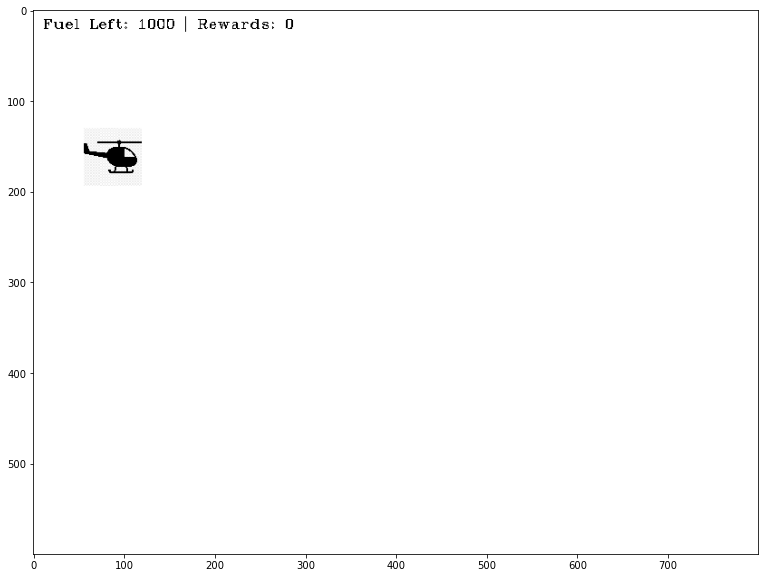

In [5]:
env = ChopperScape()
obs = env.reset()
screen = env.render(mode = "rgb_array")

plt.figure(figsize = (20,10))
plt.imshow(screen)

In [ ]:
from IPython import display

env = ChopperScape()
obs = env.reset()
while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)  
    env.render()
    if done == True:
        break

env.close()